# [PART 1] Generative Adverserial Network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, UpSampling2D, MaxPooling2D, Activation
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

from PIL import Image

## Load MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5 # normalization
# X_train = X_train[:, :, :, None]
# X_test = X_test[:, :, :, None]

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
X_train = X_train[:, :, :, None]
X_test = X_test[:, :, :, None]
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Define Model

### Generator Model

### <font color='red'>**EXERCISE**: </font>

Cobalah untuk mengubah-ubah arsitektur
* menambah layer Conv2D,
* menambah filter,
* dsb

In [9]:
def generator_model():
    model = Sequential([
        Dense(1024, input_dim=100, activation='tanh'),
        Dense(128*7*7),
        BatchNormalization(),
        Activation('tanh'),
        Reshape((7, 7, 128)),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (5, 5), padding='same', activation='tanh'),
        UpSampling2D(size=(2, 2)),
        Conv2D(1, (5, 5), padding='same', activation='tanh')
    ])
    return model

generator_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

### Discriminator Model

### <font color='red'>**EXERCISE**: </font>

Cobalah untuk mengubah-ubah arsitektur
* menambah layer Conv2D,
* menambah filter,
* dsb

In [49]:
def discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), input_shape=(28, 28, 1), padding='same', activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5),activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 128)       204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              3277824   
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

### GAN = Generator + Discriminator

In [0]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

## Training Functions
untuk melakukan training diperlukan BATCH_SIZE yang merupakan banyaknya gambar yang di train tiap epochs nya. Tiap piksel gambar akan dikonversikan menjadi nilai antara [-1,1). Hasil training akan disimpan pada file discriminator dan generator.

### Combine Generated Image

Combine Image adalah fungsi untuk menggabungkan gambar kedalam satu frame.

In [0]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

### Training Function

In [0]:
def train_gan(X_train, Y_train, batch_size, epochs, g, d, save_every=500, print_every=100):
    
    # ukuran vektor z
    z_size = g.layers[0].input_shape[1]
    
    # gabungkan Discriminator dan Generator
    d.trainable = False # set Discriminator tidak bisa dilatih sebelum digabung
    d_on_g = combine_model(g, d)    
    dg_optim = RMSprop (lr=0.0005)
    g_optim = RMSprop (lr=0.0005)
    d_on_g.compile(loss='binary_crossentropy', optimizer=dg_optim)
    
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    # set Discriminator agar bisa dilatih kembali
    d.trainable = True
    d_optim = RMSprop (lr=0.0005)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    print("Number of batches", int(X_train.shape[0]/batch_size))
    
    # mulai pelatihan
    for epoch in range(epochs):
        print("\n-------------------------------\nEpoch :", epoch)        
        
        for index in range(int(X_train.shape[0]/batch_size)):
            
            # bangkitkan matrix z secara acak
            noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # bangkitkan data gambar palsu dari matrix z
            generated_images = g.predict(noise, verbose=0)
            
            # ambil data gambar asli
            image_batch = X_train[index*batch_size:(index+1)*batch_size]
            
            if index % save_every == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                # Image.fromarray(image.astype(np.uint8)).save("train_ep"+
                #     str(epoch)+"_"+str(index)+".png")
                
                plt.imshow(image, cmap=plt.get_cmap('gray'))
                plt.axis('off')
                plt.show()
                
            # gabungkan data untuk pelatihan Discriminator
            X = np.concatenate((image_batch, generated_images))
            y = [1] * batch_size + [0] * batch_size
            
            # latih Discriminator
            d_loss = d.train_on_batch(X, y)           
            
            # bangkitkan matrix z secara acak untuk pelatihan Generator
            noise = np.random.uniform(-1, 1, (batch_size, z_size))
            
            # set Discriminator tidak bisa dilatih sebelum digabung
            d.trainable = False            
            
            # latih Generator
            g_loss = d_on_g.train_on_batch(noise, [1] * batch_size)
            
            # print loss
            if index % print_every == 0: 
                print("batch %d, g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))
            
            # set Discriminator agar bisa dilatih kembali
            d.trainable = True       
            
        
    return g, d

## Training Process

### Initialize Model

In [0]:
z_size = 100
g_model = generator_model()
d_model = discriminator_model()

### Train GAN

Number of batches 266

-------------------------------
Epoch : 0


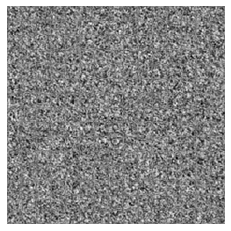

batch 0, g_loss : 0.008255, d_loss : 0.651039
batch 100, g_loss : 1.509320, d_loss : 0.642482
batch 200, g_loss : 0.921568, d_loss : 0.601169


In [54]:
batch = 225
epochs = 1
g_model, d_model = train_gan(X_train,y_train, batch, epochs, g_model, d_model)

## Generate gambar
pada fungsi ini gambar bisa digenerate dengan input BATCH_SIZE yang menunjukan jumlah gambar yang akan dibangkitkan. 

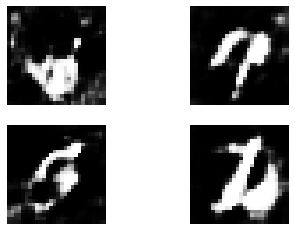

In [21]:
seed = np.random.uniform(-1, 1, (4, 100))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

### Generate Gambar dari Generator

In [0]:
def generate_images(g, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size, z_size))
    generated_images = g.predict(noise, verbose=1)
    image = combine_images(generated_images)
    filename = "generated_image.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

100/100 [==============================] - 0s 243us/sample


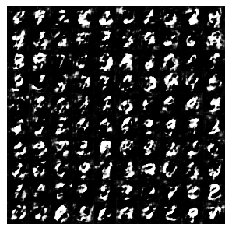

In [23]:
images = generate_images(g_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

### Generate Gambar dengan pengecekan Diskriminator

In [0]:
def generate_best_images(g, d, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size*20, z_size))

    generated_images = g.predict(noise, verbose=1)
    d_pret = d.predict(generated_images, verbose=1)

    index = np.arange(0, batch_size*20)
    index.resize((batch_size*20, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)
    filename = "generated_image_best.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

2000/2000 [==============================] - 0s 82us/sample


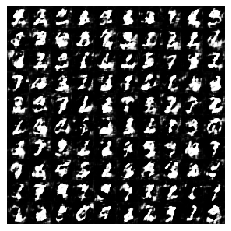

In [26]:
images = generate_best_images(g_model, d_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

---
## <font color='red'>**EXERCISE**: </font>

<font size=5>Cobalah ulangi proses PART 1 (tanpa PART 2) untuk melatih model GAN menggunakan dataset Fashion-MNIST
---

---
# [PART 2] Pengujian Latent Space

## Train MNIST Classifier
fungsi ini berguna untuk menebak label dari sebuah gambar dengan ukuran (1,28,28,1). model yang digunakan untuk mengklasifikasikan gambar adalah CNN yang sudah di train sebelumnya

In [0]:
def mnist_classifier():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        # keras.layers.Conv2D(filters, 
        # kernel_size, strides=(1, 1), 
        # padding='valid', 
        # data_format=None, 
        # dilation_rate=(1, 1), 
        # activation=None, 
        # use_bias=True, 
        # kernel_initializer='glorot_uniform', 
        # bias_initializer='zeros', 
        # kernel_regularizer=None, 
        # bias_regularizer=None, 
        # activity_regularizer=None, 
        # kernel_constraint=None, 
        # bias_constraint=None)
    
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
def train_classifier(model, batch_size, epochs):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epochs,verbose=2,validation_data=(X_test, y_test))
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', score[1])
    
    return model

In [29]:
batch = 512
mnist_model = mnist_classifier()
mnist_model = train_classifier(mnist_model, batch, 10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 6s - loss: 0.3961 - acc: 0.8783 - val_loss: 0.0825 - val_acc: 0.9733
Epoch 2/10
60000/60000 - 5s - loss: 0.1119 - acc: 0.9665 - val_loss: 0.0475 - val_acc: 0.9854
Epoch 3/10
60000/60000 - 5s - loss: 0.0825 - acc: 0.9755 - val_loss: 0.0390 - val_acc: 0.9859
Epoch 4/10
60000/60000 - 5s - loss: 0.0679 - acc: 0.9791 - val_loss: 0.0324 - val_acc: 0.9897
Epoch 5/10
60000/60000 - 5s - loss: 0.0559 - acc: 0.9837 - val_loss: 0.0309 - val_acc: 0.9893
Epoch 6/10
60000/60000 - 5s - loss: 0.0489 - acc: 0.9854 - val_loss: 0.0296 - val_acc: 0.9904
Epoch 7/10
60000/60000 - 5s - loss: 0.0438 - acc: 0.9867 - val_loss: 0.0282 - val_acc: 0.9894
Epoch 8/10
60000/60000 - 5s - loss: 0.0422 - acc: 0.9866 - val_loss: 0.0272 - val_acc: 0.9906
Epoch 9/10
60000/60000 - 5s - loss: 0.0358 - acc: 0.9886 - val_loss: 0.0271 - val_acc: 0.9909
Epoch 10/10
60000/60000 - 5s - loss: 0.0334 - acc: 0.9891 - val_loss: 0.0265 - val_acc: 0.9910
Test accu

## Test MNIST Classifier pada hasil GAN
inputnya berupa variabel seed yang berukuran (1,100) dengan rentang nilai [-1,1) 

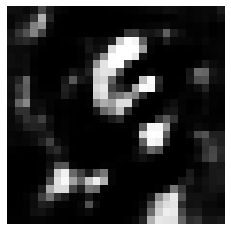

Predicted label is [5]


In [31]:
seed = np.random.uniform(-1, 1, (1, 100))

image = g_model.predict(seed)
plt.imshow(np.reshape(image, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

pred = mnist_model.predict(image)
label = np.argmax(pred, axis=1)
print('Predicted label is %s' % label)

## Test MNIST GAN in Batch 
generate 1000 gambar dan tebak labelnya, lalu masukkan kedalam dictionary seednya berdasarkan arraynya

In [32]:
seed = np.random.uniform(-1, 1, (5000, 100))
print(seed.shape)

images = g_model.predict(seed)
print(images.shape)

(5000, 100)
(5000, 28, 28, 1)


In [0]:
# Predict label
pred = mnist_model.predict(images)
y_preds = np.argmax(pred, axis=1)

### Lihat Gambar dan Hasil Klasifikasinya

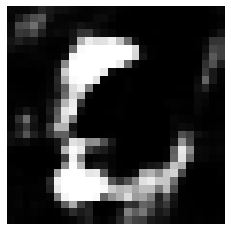

Predicted label is 5


In [34]:
id = 0

plt.imshow(np.reshape(images[id], (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()
print('Predicted label is %s' % y_preds[id])

## Kumpulkan Latent Space untuk Kelas yang sama

In [35]:
# variabel untuk menyimpan nilai seed dari tiap label
labels =  {i: [] for i in range(10)}

for idx, l in enumerate(y_preds):
    labels[l].append(seed[idx])
    
for i in range(10):
    print('jumlah kelas',i,':',np.array(labels[i]).shape)

jumlah kelas 0 : (80, 100)
jumlah kelas 1 : (188, 100)
jumlah kelas 2 : (1021, 100)
jumlah kelas 3 : (1485, 100)
jumlah kelas 4 : (313, 100)
jumlah kelas 5 : (883, 100)
jumlah kelas 6 : (134, 100)
jumlah kelas 7 : (566, 100)
jumlah kelas 8 : (81, 100)
jumlah kelas 9 : (249, 100)


### Rata-ratakan Latent Space

In [0]:
means =  {i: np.mean(np.array(labels[i]), axis=0) for i in range(10)}

### Generate Gambar Dari Rata-rata Latent Space
dengan menggunakan rata-rata dari seed sebelumnya, nilai rata-rata tersebut digunakan untuk membuat gambar baru. hasil rata-rata dikalingan dengan sebuah bilangan untuk menghasilkan gambar lainya

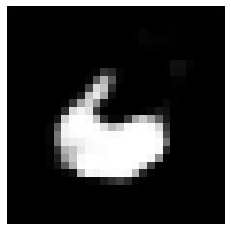

In [37]:
num = 6
mean_seed = np.reshape(means[num], (1, 100))
img = g_model.predict(mean_seed)

plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

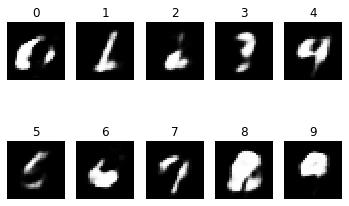

In [38]:
for i in range(10):
    mean_seed = np.reshape(means[i], (1, 100))
    img = g_model.predict(mean_seed)
    plt.subplot(2,5,1+i)
    plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
    plt.title(str(i))
    plt.axis('off')
plt.show()

## Kumpulkan Latent Space untuk Kelas yang sama [Balanced]

In [39]:
batas = 25

labels_balanced = {}
for i in range(10):
    labels_balanced[i] = []
    while len(labels_balanced[i])<batas:
        seed = np.random.uniform(-1, 1, (1, 100))
        images = g_model.predict(seed)
        pred = mnist_model.predict(images)
        y_preds = np.argmax(pred, axis=1)
        if(y_preds==i):
            labels_balanced[i].append(seed)


for i in range(10):
    print('jumlah kelas',i,':',np.array(labels_balanced[i]).shape)
    
    
means_balanced =  {i: np.mean(np.array(labels_balanced[i]), axis=0) for i in range(10)}

jumlah kelas 0 : (25, 1, 100)
jumlah kelas 1 : (25, 1, 100)
jumlah kelas 2 : (25, 1, 100)
jumlah kelas 3 : (25, 1, 100)
jumlah kelas 4 : (25, 1, 100)
jumlah kelas 5 : (25, 1, 100)
jumlah kelas 6 : (25, 1, 100)
jumlah kelas 7 : (25, 1, 100)
jumlah kelas 8 : (25, 1, 100)
jumlah kelas 9 : (25, 1, 100)


### Generate Gambar

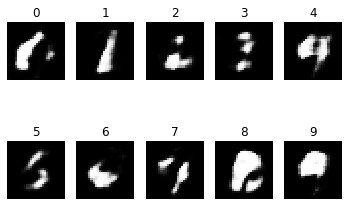

In [40]:
for i in range(10):
    mean_seed = np.reshape(means_balanced[i], (1, 100))
    img = g_model.predict(mean_seed)
    plt.subplot(2,5,1+i)
    plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
    plt.title(str(i))
    plt.axis('off')
plt.show()

# Latent Space Interpolation

Mari kita coba operasi matematis untuk masing-masing latent space

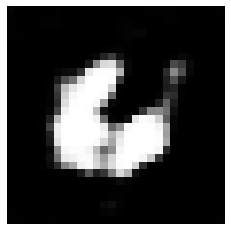

Predicted label is [6]


In [41]:
new_d = means[6] - means[1]
img = g_model.predict(np.reshape(new_d, (1, 100)))
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

pred = mnist_model.predict(img)
label = np.argmax(pred, axis=1)
print('Predicted label is %s' % label) 

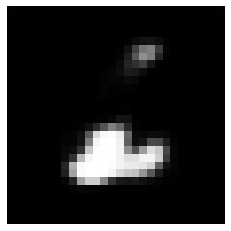

Predicted label is [2]


In [42]:
new_d = means[2] + means[5]
img = g_model.predict(np.reshape(new_d, (1, 100)))
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

pred = mnist_model.predict(img)
label = np.argmax(pred, axis=1)
print('Predicted label is %s' % label) 